In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split


In [3]:
# Define the path to the input dataset
input_dir = '/kaggle/input/cotton-leaf-dataset/Augmented Dataset/Augmented Dataset'

# Define the path to the working directory where we will save the split data
working_dir = '/kaggle/working/cotton-leaf-dataset-split'

# Create directories for train, validation, and test datasets in the working directory
train_dir = os.path.join(working_dir, 'train')
val_dir = os.path.join(working_dir, 'val')
test_dir = os.path.join(working_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [4]:
# Get list of all the classes in the dataset
classes = os.listdir(input_dir)
# Split the data for each class into train, test, and validation
for class_name in classes:
    class_path = os.path.join(input_dir, class_name)
    if os.path.isdir(class_path):
        # Get all image files for the class
        all_files = os.listdir(class_path)
        
        # Shuffle and split the data
        train_files, temp_files = train_test_split(all_files, test_size=0.3, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=2/3, random_state=42)  # 10% for validation
        
        # Create class directories in train, val, and test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        
        # Move the files to respective directories in the working directory
        for file in train_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(train_dir, class_name, file))
        for file in val_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(val_dir, class_name, file))
        for file in test_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(test_dir, class_name, file))

print("Data has been split and saved in the working directory.")

Data has been split and saved in the working directory.


In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer


In [6]:
# Set the path to the working directory containing train, validation, and test data
train_dir = '/kaggle/working/cotton-leaf-dataset-split/train'
val_dir = '/kaggle/working/cotton-leaf-dataset-split/val'
test_dir = '/kaggle/working/cotton-leaf-dataset-split/test'

# Define learning rate and other hyperparameters
initial_lr = 0.0001  # Learning rate
batch_size = 32
epochs = 50


In [7]:
# Set up data generators for train, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(224, 224),
                                                batch_size=batch_size,
                                                class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

# Define the MobileNetV2 model with pre-trained weights (without top layer for custom output)
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

Found 4900 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Add custom layers on top of the MobileNetV2 base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global average pooling to reduce dimensions
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [9]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=[early_stopping, lr_scheduler])


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732814065.907357     127 service.cc:145] XLA service 0x7dbe84001ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732814065.907415     127 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/154 ━━━━━━━━━━━━━━━━━━━━ 29:28 12s/step - accuracy: 0.2188 - loss: 2.2502

I0000 00:00:1732814071.812634     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 228ms/step - accuracy: 0.3693 - loss: 1.7072 - val_accuracy: 0.8014 - val_loss: 0.7360 - learning_rate: 1.0000e-04
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.7213 - loss: 0.8216 - val_accuracy: 0.8629 - val_loss: 0.5051 - learning_rate: 1.0000e-04
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.7865 - loss: 0.6277 - val_accuracy: 0.8829 - val_loss: 0.4239 - learning_rate: 1.0000e-04
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.8356 - loss: 0.5134 - val_accuracy: 0.8914 - val_loss: 0.3626 - learning_rate: 1.0000e-04
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - accuracy: 0.8588 - loss: 0.4353 - val_accuracy: 0.9029 - val_loss: 0.3218 - learning_rate: 1.0000e-04
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 27s 169ms/step - accuracy: 0.8730 - loss: 0.3906 - val_accuracy: 0.9100 - val_loss: 0.2969 - learning_rate: 1.0000e-04
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 27s 169ms/step - 

<Figure size 640x480 with 0 Axes>

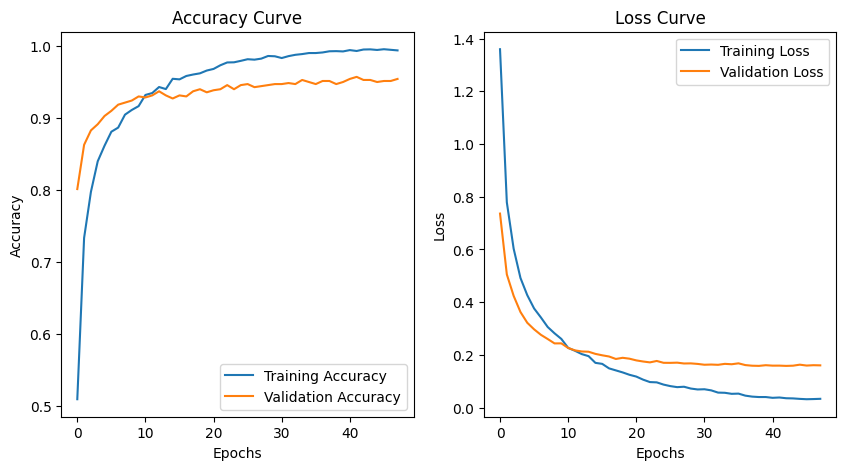

In [10]:
# Plot accuracy and loss curves
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(10, 5))  # Reduced figure size for a more compact view
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout(pad=2.0)  # Adjust the padding between plots for a more compact layout
plt.show()

plot_history(history)

44/44 - 9s - 207ms/step - accuracy: 0.9421 - loss: 0.1696
Test Accuracy: 0.9421428442001343
Test Loss: 0.1695801317691803
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step


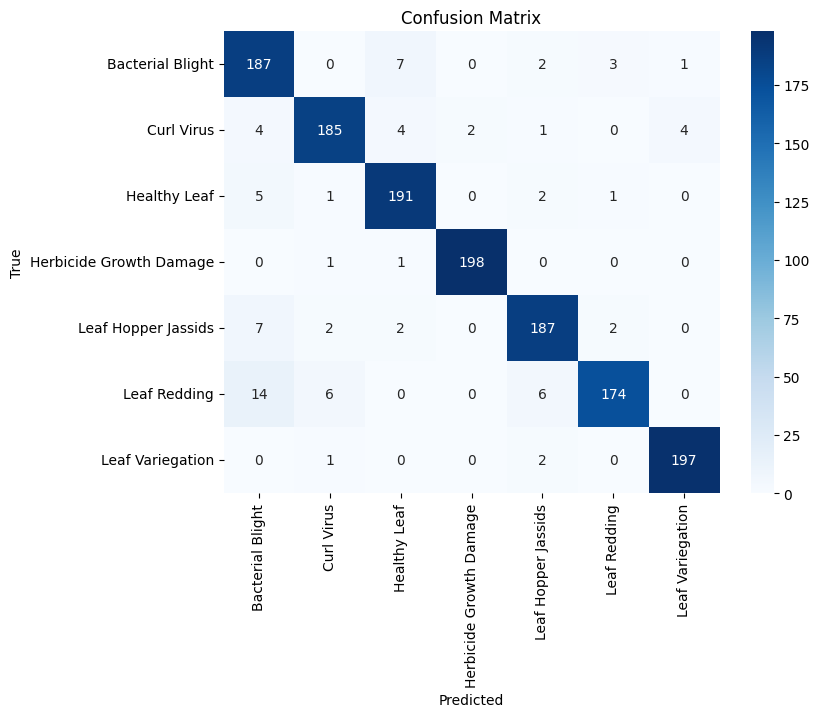

In [11]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Get predictions on the test set
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

44/44 - 7s - 152ms/step - accuracy: 0.9421 - loss: 0.1696
Test Accuracy: 0.9421428442001343
Test Loss: 0.1695801317691803
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step


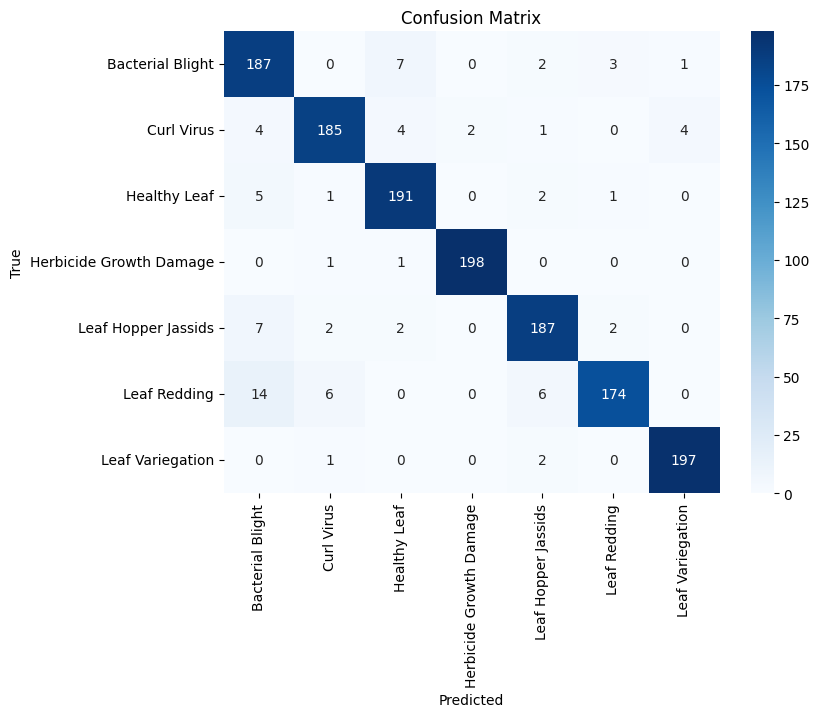

Overall Accuracy: 94.21%
Overall Precision: 94.35%
Overall Recall: 94.21%
Overall F1 Score: 94.22%

Classification Report:
                          precision    recall  f1-score   support

       Bacterial Blight       0.86      0.94      0.90       200
             Curl Virus       0.94      0.93      0.93       200
           Healthy Leaf       0.93      0.95      0.94       200
Herbicide Growth Damage       0.99      0.99      0.99       200
    Leaf Hopper Jassids       0.94      0.94      0.94       200
           Leaf Redding       0.97      0.87      0.92       200
       Leaf Variegation       0.98      0.98      0.98       200

               accuracy                           0.94      1400
              macro avg       0.94      0.94      0.94      1400
           weighted avg       0.94      0.94      0.94      1400



In [12]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Get predictions on the test set
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute overall accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')  # Weighted for multi-class
recall = recall_score(y_true, y_pred_classes, average='weighted')        # Weighted for multi-class
f1 = f1_score(y_true, y_pred_classes, average='weighted')                # Weighted for multi-class

# Print the overall metrics as percentages
print("Overall Accuracy: {:.2f}%".format(accuracy * 100))
print("Overall Precision: {:.2f}%".format(precision * 100))
print("Overall Recall: {:.2f}%".format(recall * 100))
print("Overall F1 Score: {:.2f}%".format(f1 * 100))

# Optionally, print the classification report for more details
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))
